In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 데이터 로드
file_path = 'data/시장금리.csv'
df_raw = pd.read_csv(file_path)

In [5]:
# 데이터 전처리 (행/열 변환)
# '계정항목'이 '국고채(3년)'과 '회사채(3년, AA-)'인 행을 찾음
treasury_row = df_raw[df_raw['계정항목'] == '국고채(3년)']
company_row = df_raw[df_raw['계정항목'] == '회사채(3년, AA-)']

In [6]:
# 날짜 컬럼들만 추출 (4번째 컬럼부터 날짜 데이터로 가정)
# 만약 날짜가 2010/01 형태라면 이를 인덱스로 사용
date_cols = df_raw.columns[4:]

In [7]:
# 새로운 DataFrame 생성
df = pd.DataFrame({
    'Treasury': treasury_row.iloc[0][date_cols].values,
    'Company': company_row.iloc[0][date_cols].values
}, index=date_cols)

In [8]:
# 인덱스를 날짜 형식으로 변환 및 정렬
df.index.name = '날짜'
df.index = pd.to_datetime(df.index, format='%Y/%m')
df = df.sort_index()

In [9]:
# 데이터 타입 변환 (문자열 -> 숫자)
df['Treasury'] = pd.to_numeric(df['Treasury'])
df['Company'] = pd.to_numeric(df['Company'])

In [10]:
# 신용스프레드 계산
# 공식: 회사채금리 - 국고채금리
df['Credit_Spread'] = df['Company'] - df['Treasury']

In [11]:
# 12개월 변화량 계산
# 금리는 로그 수익률보다 단순 등락폭(bp)을 주로 사용합니다.
df['12m_change'] = df['Credit_Spread'].diff(12)

In [ ]:
# Z-Score 계산
mean_val = df['12m_change'].mean()
std_val = df['12m_change'].std()

In [13]:
# 스프레드가 확대(Risk Off)되면 값이 커지므로,
# 주식 시장과 방향을 맞추기 위해 -1을 곱함 (스프레드 축소 = 호재 = 양수)
df['z_score'] = -1 * ((df['12m_change'] - mean_val) / std_val)

In [ ]:
# CSV 파일 저장
output_filename = 'Credit_Spread_Z_Score.csv'
df.to_csv(output_filename, encoding='utf-8-sig')
print(f"'{output_filename}' 파일이 저장되었습니다.")

'Credit_Spread_Z_Score.csv' 파일이 저장되었습니다.


In [15]:
# 결과 확인
print(df[['Credit_Spread', '12m_change', 'z_score']].tail())

            Credit_Spread  12m_change   z_score
날짜                                             
2025-09-01          0.462      -0.118  0.254792
2025-10-01          0.427      -0.148  0.340326
2025-11-01          0.419      -0.151  0.348879
2025-12-01          0.492      -0.154  0.357433
2026-01-01          0.501      -0.157  0.365986


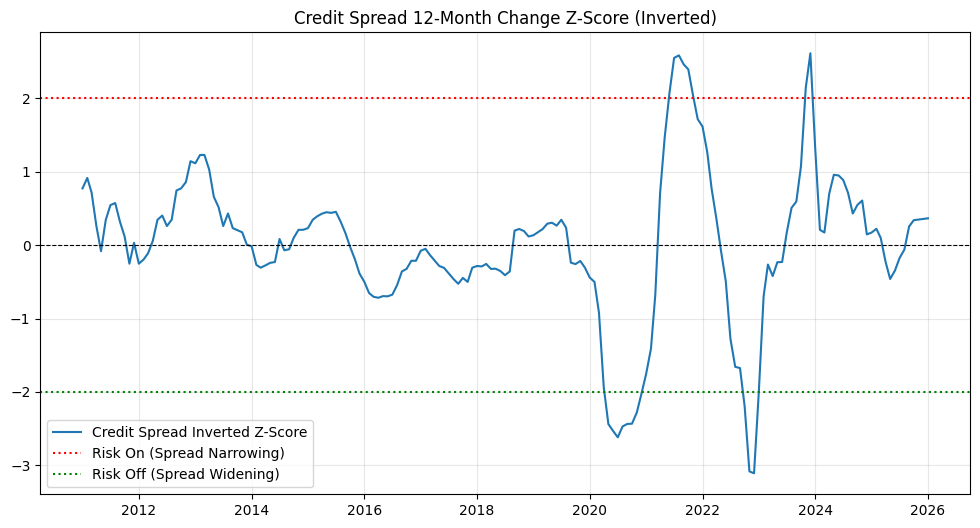

In [16]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['z_score'], label='Credit Spread Inverted Z-Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axhline(2, color='red', linestyle=':', label='Risk On (Spread Narrowing)')
plt.axhline(-2, color='green', linestyle=':', label='Risk Off (Spread Widening)')
plt.title('Credit Spread 12-Month Change Z-Score (Inverted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()